In [77]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
import datetime as dt

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt

In [3]:
windname = '/home/ecc/data/DesertDataOct/Run01/OctoberDesert1020_0_wind.hdf5'
odorname = '/home/ecc/data/DesertDataOct/Run01/OctoberDesert1020_0_odor.hdf5'
wd = hp.uncooperative_hdf5(windname)
wd

Dataset contains these keys: 
['trisonica']
Using only the first key:  trisonica


,header_seq,header_stamp_secs,header_stamp_nsecs,header_frame_id,header_stamp,speed,direction,northsouth,westeast,updown,temperature,pitch,roll,pressure,humidity,t_secs,t_nsecs,t
0,287,1603219698,575581073,b'',1.603220e+09,0.94,19.0,-0.15,-0.42,0.83,7.63,4.9,9.9,885.900024,35.599998,1603219698,576224204,1.603220e+09
1,288,1603219698,600331068,b'',1.603220e+09,1.47,27.0,-0.66,-1.30,0.15,7.39,4.9,9.9,885.900024,35.599998,1603219698,600942510,1.603220e+09
2,289,1603219698,625422954,b'',1.603220e+09,1.43,32.0,-0.75,-1.21,0.01,7.62,4.9,9.9,885.900024,35.599998,1603219698,626047771,1.603220e+09
3,290,1603219698,650298118,b'',1.603220e+09,1.44,21.0,-0.52,-1.34,0.12,7.52,4.9,9.9,885.900024,35.599998,1603219698,650777491,1.603220e+09
4,291,1603219698,675504922,b'',1.603220e+09,1.49,17.0,-0.42,-1.40,0.26,7.41,8.3,5.2,885.900024,35.599998,1603219698,675977126,1.603220e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,12273,1603219998,226118087,b'',1.603220e+09,1.67,119.0,-1.43,0.80,0.33,7.61,-9.7,1.5,885.700012,36.099998,1603219998,226828451,1.603220e+09
11987,12274,1603219998,251204013,b'',1.603220e+09,1.81,118.0,-1.54,0.82,0.48,7.82,-9.7,1.5,885.700012,36.099998,1603219998,251836811,1.603220e+09
11988,12275,1603219998,276432037,b'',1.603220e+09,1.78,136.0,-1.22,1.28,0.20,7.72,-3.7,-2.1,885.700012,36.200001,1603219998,277147461,1.603220e+09
11989,12276,1603219998,301510095,b'',1.603220e+09,1.65,124.0,-1.36,0.90,0.25,7.61,-3.7,-2.1,885.599976,36.200001,1603219998,302175900,1.603220e+09


In [4]:
time = wd.header_stamp_secs + (wd.header_stamp_nsecs*1e-9)
wd.insert(1 , 'time', time)
wd

,header_seq,time,header_stamp_secs,header_stamp_nsecs,header_frame_id,header_stamp,speed,direction,northsouth,westeast,updown,temperature,pitch,roll,pressure,humidity,t_secs,t_nsecs,t
0,287,1.603220e+09,1603219698,575581073,b'',1.603220e+09,0.94,19.0,-0.15,-0.42,0.83,7.63,4.9,9.9,885.900024,35.599998,1603219698,576224204,1.603220e+09
1,288,1.603220e+09,1603219698,600331068,b'',1.603220e+09,1.47,27.0,-0.66,-1.30,0.15,7.39,4.9,9.9,885.900024,35.599998,1603219698,600942510,1.603220e+09
2,289,1.603220e+09,1603219698,625422954,b'',1.603220e+09,1.43,32.0,-0.75,-1.21,0.01,7.62,4.9,9.9,885.900024,35.599998,1603219698,626047771,1.603220e+09
3,290,1.603220e+09,1603219698,650298118,b'',1.603220e+09,1.44,21.0,-0.52,-1.34,0.12,7.52,4.9,9.9,885.900024,35.599998,1603219698,650777491,1.603220e+09
4,291,1.603220e+09,1603219698,675504922,b'',1.603220e+09,1.49,17.0,-0.42,-1.40,0.26,7.41,8.3,5.2,885.900024,35.599998,1603219698,675977126,1.603220e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,12273,1.603220e+09,1603219998,226118087,b'',1.603220e+09,1.67,119.0,-1.43,0.80,0.33,7.61,-9.7,1.5,885.700012,36.099998,1603219998,226828451,1.603220e+09
11987,12274,1.603220e+09,1603219998,251204013,b'',1.603220e+09,1.81,118.0,-1.54,0.82,0.48,7.82,-9.7,1.5,885.700012,36.099998,1603219998,251836811,1.603220e+09
11988,12275,1.603220e+09,1603219998,276432037,b'',1.603220e+09,1.78,136.0,-1.22,1.28,0.20,7.72,-3.7,-2.1,885.700012,36.200001,1603219998,277147461,1.603220e+09
11989,12276,1.603220e+09,1603219998,301510095,b'',1.603220e+09,1.65,124.0,-1.36,0.90,0.25,7.61,-3.7,-2.1,885.599976,36.200001,1603219998,302175900,1.603220e+09


### From Here

In [27]:
fname='/home/ecc/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
wind_df.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V', 'W', 'T', 'H', 'AD', 'MD'],
      dtype='object')

In [44]:
time_diff= []
for i in range(len(wind_df.U)-1):
    time_diff.append(wind_df.time_epoch[i]-wind_df.time_epoch[i+1])
    
dt = np.mean(time_diff)

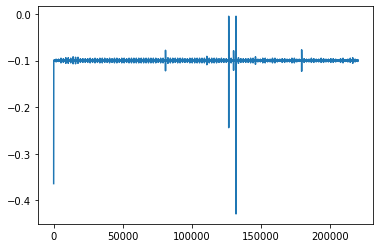

In [45]:
plt.plot(time_diff)

In [70]:
#integration of U vector
u=[]
for i in range(len(wind_df.U)-1):
    u.append(np.trapz([wind_df.U[i],wind_df.U[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
#integration of V vector
v=[]
for i in range(len(wind_df.V)-1):
    v.append(np.trapz([wind_df.V[i],wind_df.V[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
    


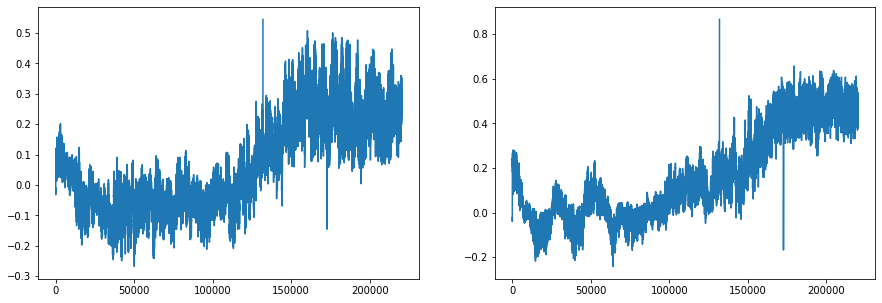

In [71]:
fig,(ax_u,ax_v)=plt.subplots(1,2,figsize=(15,5))
ax_u.plot(u)
ax_v.plot(v)

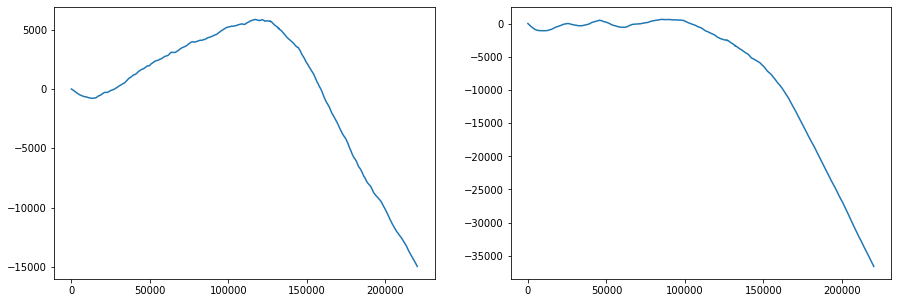

In [69]:
#without for loop integration using cumsum ; dt selected from averaging the difference of the time stamps
a=np.cumsum(wind_df.U*dt)
b=np.cumsum(wind_df.V*dt)

fig, (ax_eastwest, ax_northsouth) = plt.subplots(1,2,figsize=(15,5))

ax_eastwest.plot(a)
ax_northsouth.plot(b)

In [54]:
# arr1 =[]
# arr2 =[]
# for i in range(len(y)):
#     if i==0:
#         arr1.append(0)
#     else:
#         arr1.append(y[i]+arr1[i-1])

# for i in range(len(z)):
#     if i==0:
#         arr2.append(0)
#     else:
#         arr2.append(z[i]+arr2[i-1])

# #arr1 = U zonal velocity ; eastwest
# #arr2 = V meridian velocity; Northsouth
# particle = list(zip(arr1, arr2))
# particle

In [11]:
#plt.plot(*zip(*particle))

#to ask: how to scale this time with the bag from the setup
#to ask: how to match the time of small bags with the stationery wind data 
#to ask: the plot is on the negative axis 

In [200]:
od = hp.uncooperative_hdf5(odorname)
od

Dataset contains these keys: 
['analog_output']
Using only the first key:  analog_output


,data,t_secs,t_nsecs,t
0,0.671380,1603219698,572021154,1.603220e+09
1,0.670128,1603219698,577018085,1.603220e+09
2,0.669503,1603219698,582246585,1.603220e+09
3,0.669816,1603219698,587173698,1.603220e+09
4,0.672631,1603219698,592109752,1.603220e+09
...,...,...,...,...
59948,1.206925,1603219998,312229822,1.603220e+09
59949,1.201919,1603219998,317187629,1.603220e+09
59950,1.175017,1603219998,322268602,1.603220e+09
59951,1.162192,1603219998,327180133,1.603220e+09


In [201]:
a=dt.datetime.utcfromtimestamp(float(0))
dtx=[]
for i in range (len(od.t)):
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    dtx.append((dt.datetime.fromtimestamp(od.t[i])-a).total_seconds()) 

od.insert(1,'epoch',dtx)
sync_time = od.epoch-od.epoch[0]
od.insert(2,'sync_time',sync_time)

In [202]:
od

,data,epoch,sync_time,t_secs,t_nsecs,t
0,0.671380,1.603194e+09,0.000000,1603219698,572021154,1.603220e+09
1,0.670128,1.603194e+09,0.004997,1603219698,577018085,1.603220e+09
2,0.669503,1.603194e+09,0.010226,1603219698,582246585,1.603220e+09
3,0.669816,1.603194e+09,0.015153,1603219698,587173698,1.603220e+09
4,0.672631,1.603194e+09,0.020089,1603219698,592109752,1.603220e+09
...,...,...,...,...,...,...
59948,1.206925,1.603195e+09,299.740209,1603219998,312229822,1.603220e+09
59949,1.201919,1.603195e+09,299.745167,1603219998,317187629,1.603220e+09
59950,1.175017,1.603195e+09,299.750247,1603219998,322268602,1.603220e+09
59951,1.162192,1.603195e+09,299.755159,1603219998,327180133,1.603220e+09


### Till here

Text(0, 0.5, 'Odor Concentration')

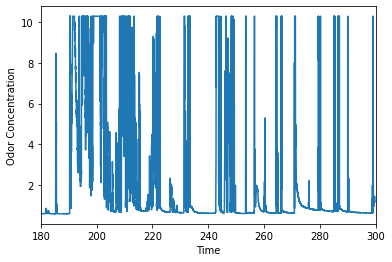

In [203]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(od.sync_time, od.data)
ax.set_xlim(180,300)
ax.set_xlabel('Time')
ax.set_ylabel('Odor Concentration')

In [16]:
dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv") 
dfbag01

,time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,_trisonica_pitch,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603220e+09,0.671380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603220e+09,NaN,19.0,NaN,287.0,575581073.0,1.603220e+09,35.599998,-0.15,4.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603220e+09,0.670128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603220e+09,0.669503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603220e+09,0.669816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73438,1.603220e+09,1.201919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73439,1.603220e+09,1.175017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73440,1.603220e+09,NaN,111.0,NaN,12277.0,326195001.0,1.603220e+09,36.200001,-1.37,-3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73441,1.603220e+09,1.162192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:

dfbag01=dfbag01.interpolate()
#to ask: too many nan is interpolating a good idea?

Text(0, 0.5, 'Latitude')

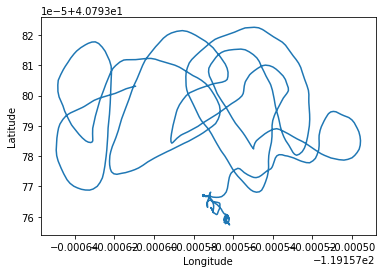

In [18]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag01._ublox_gps_fix_longitude, dfbag01._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [19]:
#creating epoch for CSV
epoch_time=dfbag01.time-dfbag01.time[0]
dfbag01.insert(1,'epoch',epoch_time)

In [20]:
query = 'epoch > 75 and epoch < 150'
df_gps= dfbag01.query(query)
df_gps

,time,epoch,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
18376,1.603220e+09,75.01,0.665592,197.000000,NaN,3287.000000,5.756330e+08,1.603220e+09,36.599998,0.170000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000155,2.0,3.0,2.0
18377,1.603220e+09,75.01,0.664810,195.666667,NaN,3287.166667,5.798204e+08,1.603220e+09,36.599998,0.158333,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000154,2.0,3.0,2.0
18378,1.603220e+09,75.01,0.667000,194.333333,NaN,3287.333333,5.840077e+08,1.603220e+09,36.599998,0.146667,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000154,2.0,3.0,2.0
18379,1.603220e+09,75.02,0.665123,193.000000,NaN,3287.500000,5.881950e+08,1.603220e+09,36.599998,0.135000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000153,2.0,3.0,2.0
18380,1.603220e+09,75.02,0.666375,191.666667,NaN,3287.666667,5.923823e+08,1.603220e+09,36.599998,0.123333,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000153,2.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36744,1.603220e+09,149.98,0.607565,86.166667,NaN,6285.833333,5.464691e+08,1.603220e+09,36.400002,-0.860000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
36745,1.603220e+09,149.98,0.607877,86.000000,NaN,6286.000000,5.506380e+08,1.603220e+09,36.400002,-0.930000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
36746,1.603220e+09,149.98,0.608190,83.166667,NaN,6286.166667,5.548255e+08,1.603220e+09,36.400002,-0.918333,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
36747,1.603220e+09,149.99,0.606001,80.333333,NaN,6286.333333,5.590130e+08,1.603220e+09,36.400002,-0.906667,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0


In [21]:
source_location_lat=df_gps._ublox_gps_fix_latitude.mean()
source_location_long=df_gps._ublox_gps_fix_longitude.mean()
source_location=[source_location_lat, source_location_long]
source_location

[40.79376709443614, -119.15757512132207]

In [22]:
query = '_analog_output_data > 5 and _analog_output_data <= 10'
df_tmp = dfbag01.query(query)
df_tmp

,time,epoch,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
45414,1.603220e+09,185.36,5.333311,182.000000,NaN,7701.285714,9.334688e+08,1.603220e+09,39.000000,0.034286,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
45415,1.603220e+09,185.37,6.160402,180.000000,NaN,7701.428571,9.370522e+08,1.603220e+09,39.000000,0.001429,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
45416,1.603220e+09,185.37,6.695322,178.000000,NaN,7701.571429,9.406357e+08,1.603220e+09,39.000000,-0.031429,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
45417,1.603220e+09,185.38,6.934002,176.000000,NaN,7701.714286,9.442191e+08,1.603220e+09,39.000000,-0.064286,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
45418,1.603220e+09,185.38,8.327295,174.000000,NaN,7701.857143,9.478025e+08,1.603220e+09,39.000000,-0.097143,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70320,1.603220e+09,287.02,6.761639,176.500000,NaN,11767.500000,5.894165e+08,1.603220e+09,35.799999,-0.105000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000204,2.0,3.0,2.0
71052,1.603220e+09,290.01,5.602960,238.000000,NaN,11887.000000,5.761471e+08,1.603220e+09,35.799999,2.060000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000158,2.0,3.0,2.0
73251,1.603220e+09,298.98,8.789327,139.833333,NaN,12246.166667,5.553459e+08,1.603220e+09,36.099998,-0.896667,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0
73281,1.603220e+09,299.11,7.075396,130.375000,NaN,12250.875000,6.734135e+08,1.603220e+09,36.099998,-1.258750,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.000100,2.0,3.0,2.0


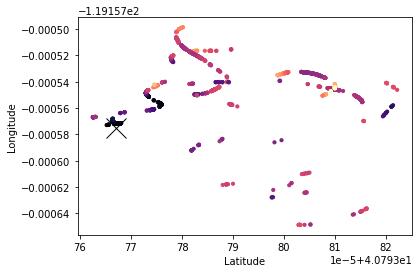

In [23]:
fig_odor_gps = plt.figure()
ax_odor_gps_filtered = fig_odor_gps.add_subplot(111)
ax_odor_gps_filtered.scatter(df_tmp._ublox_gps_fix_latitude, df_tmp._ublox_gps_fix_longitude, c=df_tmp._ublox_gps_fix_altitude, s=10, cmap='magma')
ax_odor_gps_filtered.set_xlabel('Latitude')
ax_odor_gps_filtered.set_ylabel('Longitude')

plt.plot([40.79376709443614], [-119.15757512132207], marker='x', markersize=20, color="black")

In [24]:
dfbag02 = hp.import_csv("~/data/DesertDataOct/Run02/OctoberRun02Bag0.csv") 
dfbag02

,time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,_trisonica_pitch,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603221e+09,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603221e+09,0.635718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603221e+09,NaN,256.0,NaN,1.0,554316043.0,1.603221e+09,34.799999,1.16,-3.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603221e+09,0.634467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603221e+09,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73433,1.603221e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73434,1.603221e+09,0.593488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73435,1.603221e+09,NaN,135.0,NaN,11990.0,280133008.0,1.603221e+09,32.000000,-1.38,-3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73436,1.603221e+09,0.592237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
dfbag02=dfbag02.interpolate()
#creating epoch for CSV
epoch_time=dfbag02.time-dfbag02.time[0]
dfbag02.insert(1,'epoch_time',epoch_time)

In [26]:
dfbag02
#to ask: need to plot the smaller odor encounters with the wind particule simulation

,time,epoch_time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603221e+09,0.00,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603221e+09,0.00,0.635718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603221e+09,0.00,0.635093,256.000000,NaN,1.000000,5.543160e+08,1.603221e+09,34.799999,1.160000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603221e+09,0.01,0.634467,255.666667,NaN,1.166667,5.584835e+08,1.603221e+09,34.799999,1.160000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603221e+09,0.01,0.636031,255.333333,NaN,1.333333,5.626510e+08,1.603221e+09,34.799999,1.160000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73433,1.603221e+09,299.72,0.593019,125.000000,NaN,11989.714286,2.730362e+08,1.603221e+09,32.000000,-1.471429,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73434,1.603221e+09,299.73,0.593488,130.000000,NaN,11989.857143,2.765846e+08,1.603221e+09,32.000000,-1.425714,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73435,1.603221e+09,299.73,0.592862,135.000000,NaN,11990.000000,2.801330e+08,1.603221e+09,32.000000,-1.380000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73436,1.603221e+09,299.73,0.592237,135.000000,NaN,11990.000000,2.801330e+08,1.603221e+09,32.000000,-1.380000,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
